<a href="https://colab.research.google.com/github/arielmagbanua/image-classifiers/blob/main/mask-on-mask-off/moo_20210313.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import zipfile
import pathlib
import PIL
import numpy as np
from google.colab import files
from google.colab import drive
import time
import random

!pip install tensorflowjs

# mount the google drive
drive.mount('/content/drive')

     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 112kB 8.0MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extract and Prepare Dataset

1.) Mount your Google Drive

2.) Designate a directory where you want to extract your dataset (E.g. `/content/mask-on-mask-off`).

In [2]:
# The path where to extract the dataset
ARCHIVED_DATASET_PATH = '/content/drive/MyDrive/mlds/dataset/mask_on_off.zip'
COLAB_DATA_SET_PATH = '/content/sample_data/mask-on-mask-off'

# clean up directory
!rm -R $COLAB_DATA_SET_PATH

zip_ref = zipfile.ZipFile(ARCHIVED_DATASET_PATH, 'r')
zip_ref.extractall(COLAB_DATA_SET_PATH)
zip_ref.close()

rm: cannot remove '/content/sample_data/mask-on-mask-off': No such file or directory


# Constants / Parameters

In [3]:
DESIRED_ACCURACY = 0.99

dataset_path = os.path.join(COLAB_DATA_SET_PATH)
print(dataset_path)

IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

/content/sample_data/mask-on-mask-off


# Callbacks and Early Stopping

In [6]:
class DesiredAccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      self.model.stop_training = True

desired_accuract_callback = DesiredAccuracyCallback()

# stop when loss is not decreasing
# loss_monitor_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='loss',
#     mode='min',
#     patience=10
# )

# stop when accuracy is not inceasing
# accuracy_monitor_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='accuracy',
#     mode='max',
#     patience=5
# )

# create the callbacks
callbacks = [desired_accuract_callback]

# Build the Model

In [10]:
model = tf.keras.models.Sequential([
  # input layer
  # first convolution
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),

  # second convolution
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  # third convolution
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  # fourth convolution
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  # fifth convolution
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  # Flatten the results to feed into a DNN
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

  # Only 1 output neuron.
  # It will contain a value from 0-1 where 0 for 1 class ('mask on') and 1 for the other ('mask off')
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 510, 510, 128)     3584      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 255, 255, 128)     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 253, 253, 64)      73792     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 60, 60, 32)       

# Compile the Model

In [12]:
model.compile(
  loss='binary_crossentropy',
  optimizer = Adam(learning_rate=0.0005),
  metrics=['accuracy']
)

# Prepare Dataset with Data Generator

In [13]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
  rescale=1./255,
  shear_range=0.2,
  zoom_range=0.2,
  height_shift_range=0.2,
  rotation_range=30,
  horizontal_flip=True,
  validation_split=0.2
)

# training data generator
train_generator = train_datagen.flow_from_directory(
  dataset_path,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size=32,
  class_mode='binary',
  subset='training'
)

# validation data generator
validation_generator = train_datagen.flow_from_directory(
  dataset_path,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size=32,
  class_mode='binary',
  subset='validation'
)

Found 5056 images belonging to 2 classes.
Found 1264 images belonging to 2 classes.


# Train / Fit

In [14]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=12,
  epochs=150,
  verbose=1,
  callbacks=callbacks
)

Epoch 1/150
12/12 [==============================] - 135s 9s/step - loss: 0.6923 - accuracy: 0.5195 - val_loss: 0.6965 - val_accuracy: 0.4549
Epoch 2/150
12/12 [==============================] - 93s 8s/step - loss: 0.6780 - accuracy: 0.5533 - val_loss: 0.7574 - val_accuracy: 0.4304
Epoch 3/150
12/12 [==============================] - 93s 8s/step - loss: 0.6105 - accuracy: 0.6506 - val_loss: 0.8773 - val_accuracy: 0.4723
Epoch 4/150
12/12 [==============================] - 93s 8s/step - loss: 0.5397 - accuracy: 0.7263 - val_loss: 0.6850 - val_accuracy: 0.5498
Epoch 5/150
12/12 [==============================] - 93s 8s/step - loss: 0.5169 - accuracy: 0.7495 - val_loss: 0.7671 - val_accuracy: 0.5269
Epoch 6/150
12/12 [==============================] - 92s 8s/step - loss: 0.4837 - accuracy: 0.7691 - val_loss: 0.6076 - val_accuracy: 0.6464
Epoch 7/150
12/12 [==============================] - 93s 8s/step - loss: 0.4202 - accuracy: 0.8184 - val_loss: 0.6449 - val_accuracy: 0.6566
Epoch 8/150


# Plot the Training History

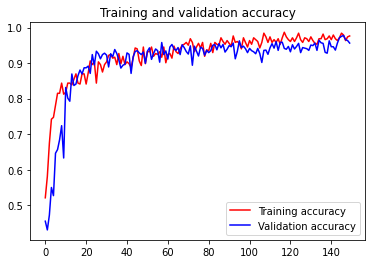

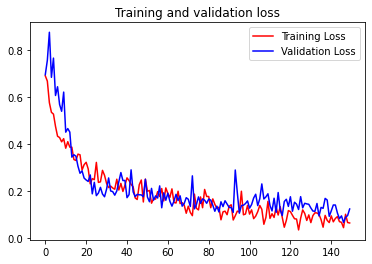

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Evaluate the Model

In [16]:
def infer(class_names, model, x):
  
  prediction = model.predict(x)
  result_index = np.argmax(prediction)
  probability = prediction[0][result_index]
  prediction_class_index = round(prediction[0][result_index])

  return probability, class_names[prediction_class_index]

Found 28 files belonging to 2 classes.


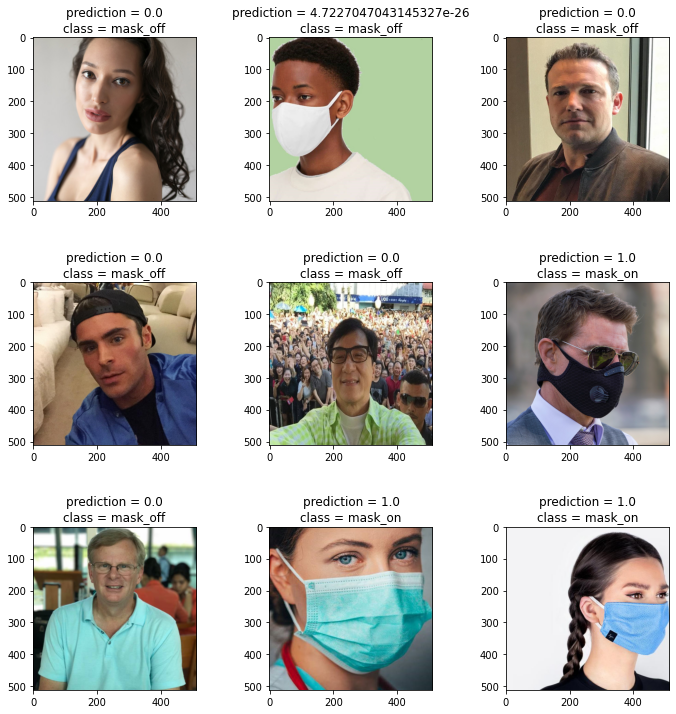

In [21]:
COLAB_EVAL_DATASET_PATH = '/content/drive/MyDrive/mlds/dataset/evaluation_data_set'
data_dir = pathlib.Path(COLAB_EVAL_DATASET_PATH)

eval_ds = tf.keras.preprocessing.image_dataset_from_directory(
  COLAB_EVAL_DATASET_PATH,
  seed=123,
  image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
)

class_names = eval_ds.class_names

# ma_onsk on inference example
samples = 9
mask_on_image_paths = list(data_dir.glob('mask_on/*.jpg'))
mask_off_image_paths = list(data_dir.glob('mask_off/*.jpg'))
image_paths = mask_on_image_paths + mask_off_image_paths
random.shuffle(image_paths)

paths_sample = random.sample(image_paths, samples)

plt.figure(figsize=(12, 12))

for i in range(samples):
  image = tf.keras.preprocessing.image.load_img(paths_sample[i])
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  image = tf.keras.preprocessing.image.img_to_array(image)

  plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.imshow(image.astype("uint8"))
  # plt.axis("off")

  image_input = tf.expand_dims(image, axis=0)
  probability, class_name = infer(class_names, model, image_input)
  plt.title('prediction = {}\nclass = {}'.format(probability, class_name))

# Save the Model

In [18]:
models_dir_path = '/content/models'
model_path = models_dir_path + '/moo.h5'

model.save(model_path)

# Convert the Model to Javascript

In [19]:
!tensorflowjs_converter --input_format keras $model_path $models_dir_path

zip_store_path = '/content/drive/MyDrive/ml_ai/moo_models_{}.zip'.format(int(time.time()))

!zip -r $zip_store_path $models_dir_path

2021-03-13 06:33:20.076388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
  adding: content/models/ (stored 0%)
  adding: content/models/model.json (deflated 88%)
  adding: content/models/moo.h5 (deflated 14%)
  adding: content/models/group1-shard1of1.bin (deflated 8%)


# Download All Models

In [ ]:
files.download(zip_store_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>